In [1]:
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import numpy as np
import pandas as pd
import time
import tqdm
from sklearn.cluster import KMeans, DBSCAN
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import pickle
import scipy.stats as stats
# from sklearn.metrics import silhouette_score

In [2]:
my_dir = ''
if my_dir != 'jupyter':
    plt.style.use('dark_background')

In [3]:
unique_customers_numeric = pickle.load(open(my_dir + 'unique_customers_numeric', 'rb'))
unique_customers = pickle.load(open(my_dir + 'unique_customers', 'rb'))
unique_customers_numeric_scaled = StandardScaler().fit_transform(unique_customers_numeric)

doublons_col = [col for col in unique_customers_numeric if col.endswith('_y')]
unique_customers_numeric = unique_customers_numeric.drop(columns=doublons_col, errors='ignore')

In [4]:
categories = [u[6:] for u in unique_customers_numeric.columns if u.startswith('price_')]
for cat in categories:
    bought_this = (unique_customers_numeric['price_' + cat] > 0) | (unique_customers_numeric['freight_value_' + cat] > 0)
    unique_customers_numeric['bool_' + cat] = bought_this.replace(False, 0).replace(True, 1)
unique_customers_numeric = unique_customers_numeric.drop(columns=['freight_value_' + c for c in categories])

## RAW - KMEANS

## SCALED - KMEANS (cherche k)

In [5]:
inertias = []
silhouettes = []
max_k = 10

possible_k = list(range(2, max_k + 1))
for k in tqdm.tqdm(possible_k):
    print(k, datetime.fromtimestamp(time.time()))
    kmeans = KMeans(n_clusters=k, max_iter=17000).fit(unique_customers_numeric_scaled)
    inertias.append(kmeans.inertia_)
    # silhouettes.append(silhouette_score(unique_customers_numeric_scaled, list(kmeans.labels_)))

100%|██████████| 9/9 [00:18<00:00,  2.05s/it]


2 2021-11-24 03:35:12.899908
3 2021-11-24 03:35:13.681185
4 2021-11-24 03:35:14.543798
5 2021-11-24 03:35:17.453933
6 2021-11-24 03:35:19.122613
7 2021-11-24 03:35:21.781331
8 2021-11-24 03:35:23.843765
9 2021-11-24 03:35:27.079227
10 2021-11-24 03:35:29.116671


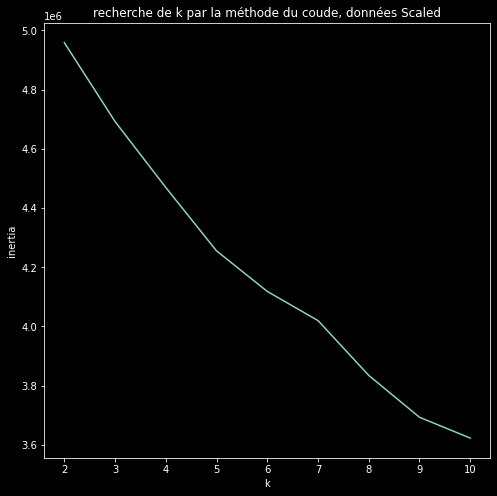

In [6]:
plt.figure(figsize=(8, 8))
plt.plot(possible_k, inertias)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('recherche de k par la méthode du coude, données Scaled')
plt.show()

In [7]:
if len(silhouettes) > 0:
    plt.figure(figsize=(10, 10))
    plt.plot(possible_k, silhouettes)
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('recherche de k par le silhouette score, données Scaled')
    plt.show()

In [8]:
def display_circles(pcs, n_comp, pca, axis_ranks, feat_labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            fig, ax = plt.subplots(figsize=(7,6))

            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))

            if feat_labels is not None:
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if xmin <= x <= xmax and ymin <= y <= ymax :
                        plt.text(x, y, feat_labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)

            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

100%|██████████| 6/6 [02:55<00:00, 29.27s/it]
/Users/julie/PycharmProjects/misc/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


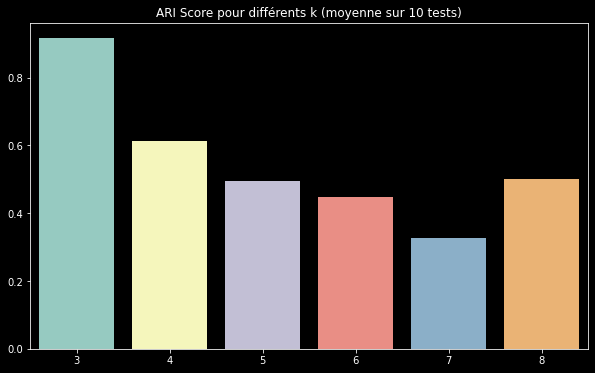

In [9]:
possible_k = [3, 4, 5, 6, 7, 8]
ari_scores = dict({k: [] for k in possible_k})
nb_random_tests = 10

for chosen_k in tqdm.tqdm(possible_k):
    for _ in range(nb_random_tests):
        labels_1 = KMeans(n_clusters=chosen_k).fit(unique_customers_numeric_scaled).labels_
        labels_2 = KMeans(n_clusters=chosen_k).fit(unique_customers_numeric_scaled).labels_
        ari_scores[chosen_k].append(adjusted_rand_score(labels_1, labels_2))

ari_scores_mean = [np.mean(ari_scores[k]) for k in possible_k]
plt.figure(figsize=(10, 6))
sns.barplot(possible_k, ari_scores_mean)
plt.title('ARI Score pour différents k (moyenne sur 10 tests)')
plt.show()

chosen_k = 3

In [10]:
import random
nb_tests = 10
max_max_iter = 30

random_states = [random.randint(0, 1000) for _ in range(nb_tests)]
accuracy = pd.DataFrame(columns=['accuracy', 'random_state', 'nb_iter'])

for rs in tqdm.tqdm(random_states):
    last_group = KMeans(n_clusters=chosen_k, max_iter=100, random_state=rs).fit(unique_customers_numeric_scaled).labels_

    kmeans_labels = pd.DataFrame()
    for max_iter in range(1, max_max_iter + 1):
        the_labels = KMeans(n_clusters=chosen_k, max_iter=max_iter, random_state=rs).fit(unique_customers_numeric_scaled).labels_
        print('#', end='')
        accuracy.loc[len(accuracy)] = [(the_labels == last_group).sum() / the_labels.shape[0], rs, max_iter]
    print()

100%|██████████| 10/10 [04:02<00:00, 24.27s/it]


##############################
##############################
##############################
##############################
##############################
##############################
##############################
##############################
##############################
##############################


<AxesSubplot:title={'center':'Kmeans Stability'}, xlabel='maximum iterations in kmeans', ylabel='Percentage of customers in their definitive group'>

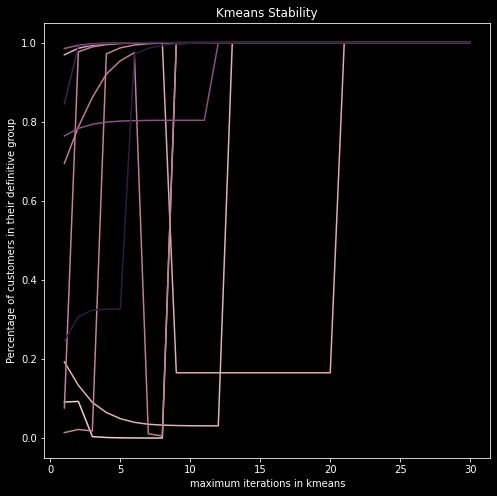

In [11]:
plt.figure(figsize=(8,8))
plt.title('Kmeans Stability')
plt.xlabel('maximum iterations in kmeans')
plt.ylabel('Percentage of customers in their definitive group')
sns.lineplot(data=accuracy, hue='random_state', x='nb_iter', y='accuracy', legend=False)

In [12]:
accuracy[accuracy['nb_iter'] == max_max_iter]

,accuracy,random_state,nb_iter
29,1.0,338.0,30.0
59,1.0,946.0,30.0
89,1.0,894.0,30.0
119,1.0,130.0,30.0
149,1.0,531.0,30.0
179,1.0,1.0,30.0
209,1.0,596.0,30.0
239,1.0,372.0,30.0
269,1.0,154.0,30.0
299,1.0,347.0,30.0


In [13]:
nb_comp = 20
features = unique_customers_numeric.columns

my_pca = decomposition.PCA(n_components=nb_comp)
my_pca.fit(unique_customers_numeric_scaled)
customers_transformed = my_pca.transform(unique_customers_numeric_scaled)
#display_circles(pca.components_, nb_comp, pca, [(0,1),(2,3),(4,5)], feat_labels = np.array(features))

## SCALED - KMEANS k = 3 max_iter = 30

In [14]:
kmeans = KMeans(n_clusters=chosen_k, random_state=42, max_iter=30).fit(unique_customers_numeric_scaled)

classified_transformed_customers = pd.DataFrame(customers_transformed)
classified_customers = pd.DataFrame(unique_customers_numeric)
classified_transformed_customers['kmeans_group'] = kmeans.labels_
classified_customers['kmeans_group'] = kmeans.labels_
kmeans_palette = sns.color_palette("colorblind", len(set(kmeans.labels_)))

nb groups : 3


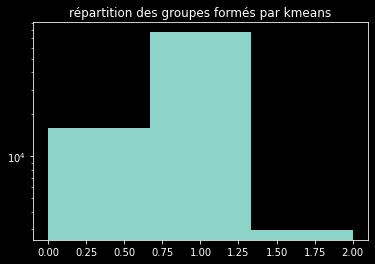

In [15]:
nb_groups = len(set(kmeans.labels_))
print('nb groups :', nb_groups)
plt.hist(kmeans.labels_, log=True, bins=nb_groups)
plt.title("répartition des groupes formés par kmeans")
plt.show()

### scatter sur les axes de l'ACP

In [16]:
Counter(kmeans.labels_)

Counter({1: 77240, 0: 15882, 2: 2974})

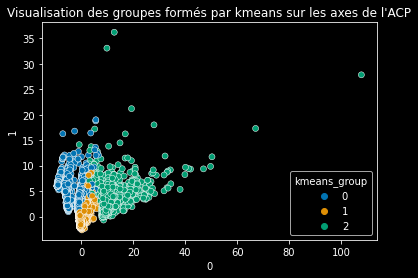

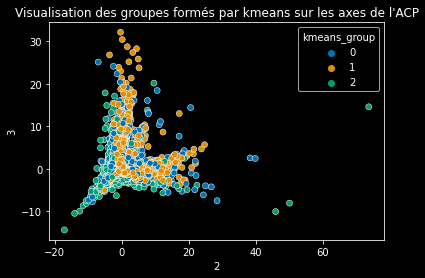

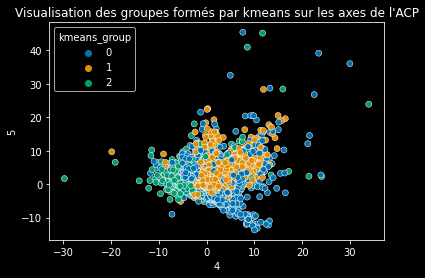

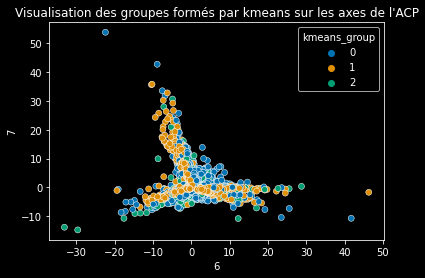

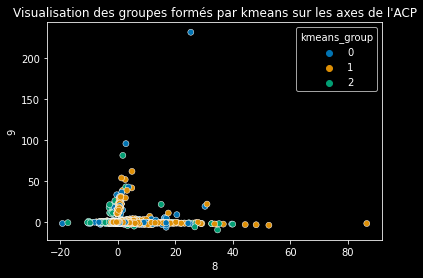

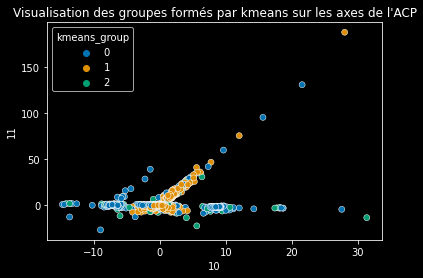

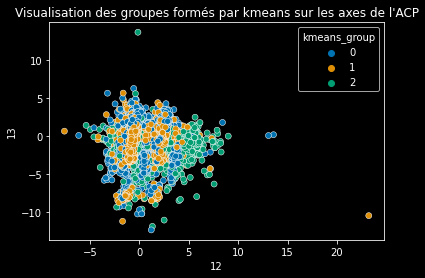

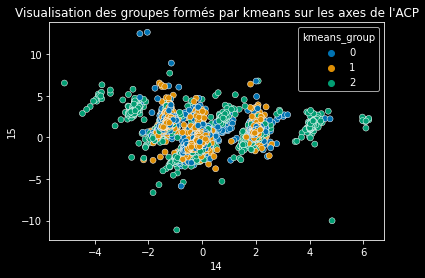

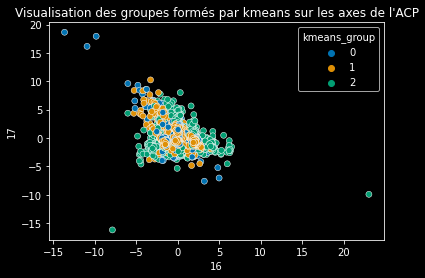

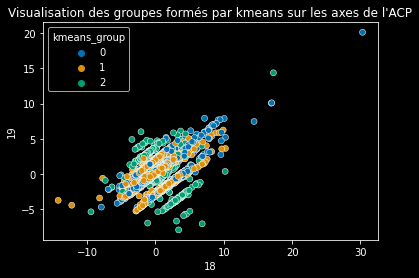

In [17]:
for j in range(nb_comp//2):
    plt.figure()
    plt.title("Visualisation des groupes formés par kmeans sur les axes de l'ACP")
    sns.scatterplot(data=classified_transformed_customers, x=2*j, y=2*j+1,
                    hue="kmeans_group", palette=kmeans_palette, legend='full')

### boxplot de chacune des features

In [18]:
%matplotlib inline

PRICE_ART

###
PRICE_BODY

###
PRICE_FOOD_DRINK

###
PRICE_HOME_CONSTRUCTION

###
PRICE_HOME_EVERYDAY

###
PRICE_MISC

###
PRICE_PROFESSIONAL

###
PRICE_UTILITIES_HOBBIES

###
ITEMS_COUNT_ART

###
ITEMS_COUNT_BODY

###
ITEMS_COUNT_FOOD_DRINK

###
ITEMS_COUNT_HOME_CONSTRUCTION

###
ITEMS_COUNT_HOME_EVERYDAY

###
ITEMS_COUNT_MISC

###
ITEMS_COUNT_PROFESSIONAL
diff moyenne non significative
F_onewayResult(statistic=2.199174793551868, pvalue=0.11090021288405622)
ITEMS_COUNT_UTILITIES_HOBBIES

###
REVIEW_SCORE_MIN

###
REVIEW_SCORE_MAX

###
REVIEW_SCORE_LAST

###
REVIEW_SCORE_COUNT

###
ORDER_TO_DOOR_DURATION_MIN

###
ORDER_TO_DOOR_DURATION_MAX

###
NB_UNIQUE_ITEMS

###
NB_ORDERS

###
STATUS_ABORTED_X

###
STATUS_FULFILLED_X

###
STATUS_ONGOING_X

###
ORDERED_WEEKDAY

###
ORDERED_WEEKEND

###
ORDERED_AFTERNOON

###
ORDERED_EARLY

###
ORDERED_EVENING

###
ORDERED_LUNCH

###
ORDERED_MORNING

###
ORDERED_NIGHT

###
BOLETO

###
CREDIT_CARD

###
DEBIT_CARD
diff moyenne non significative
F_oneway

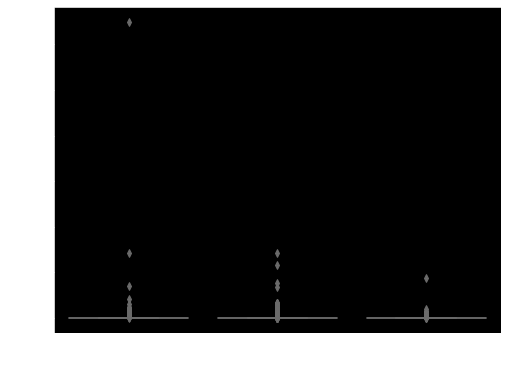

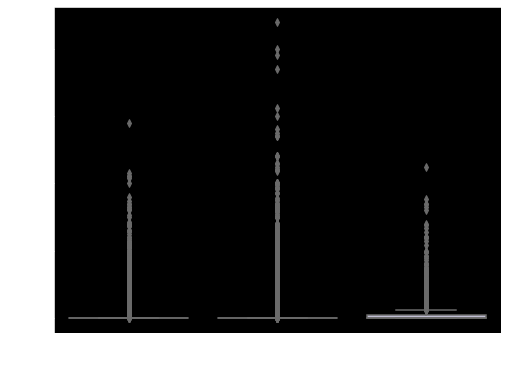

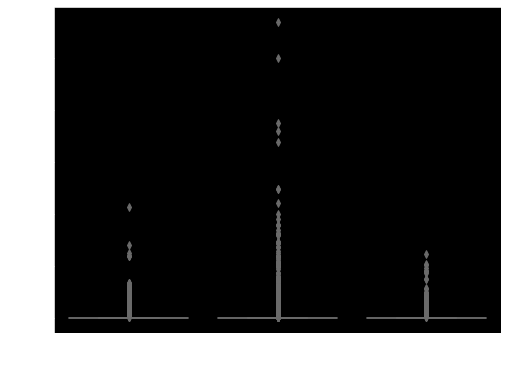

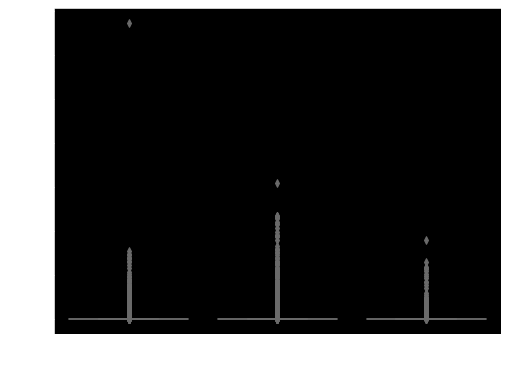

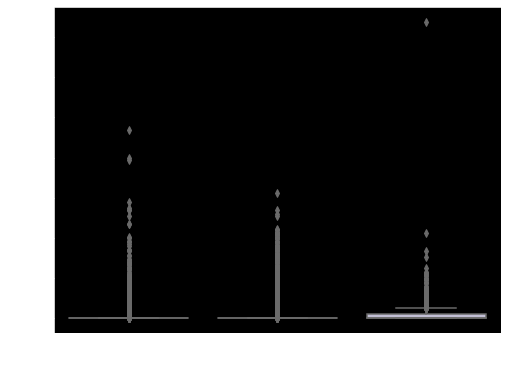

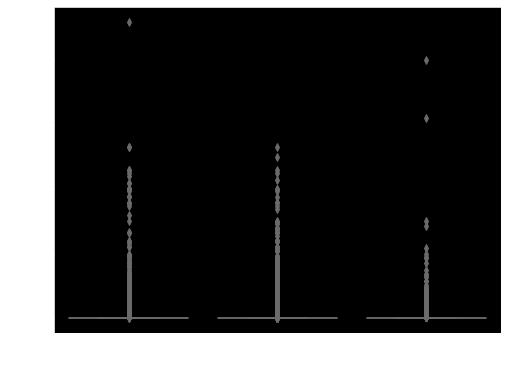

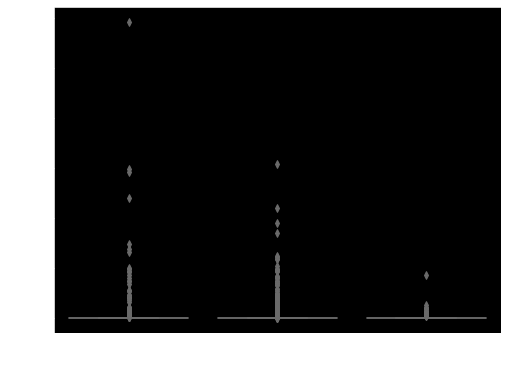

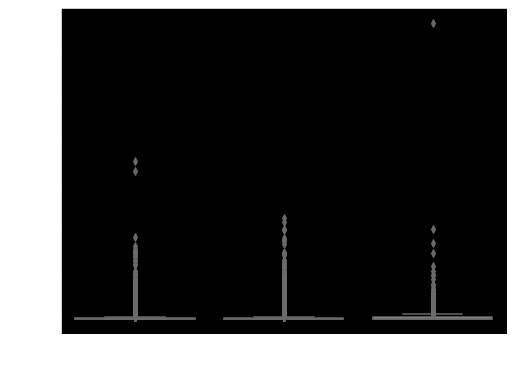

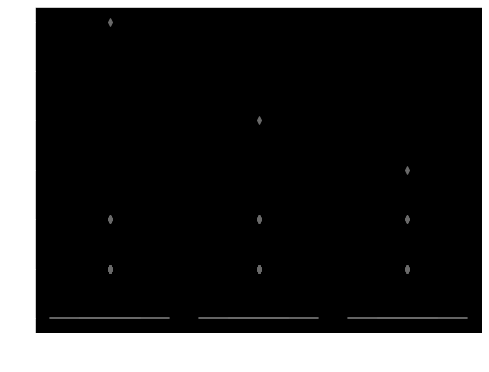

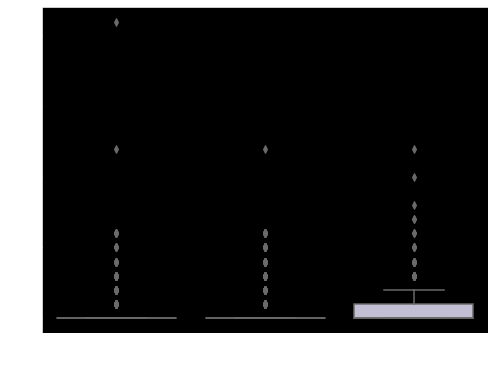

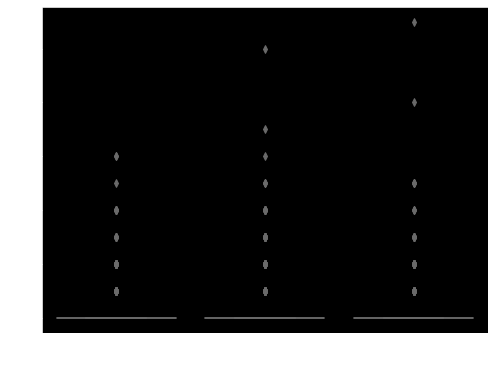

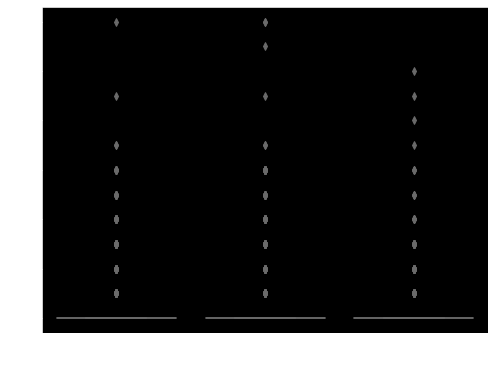

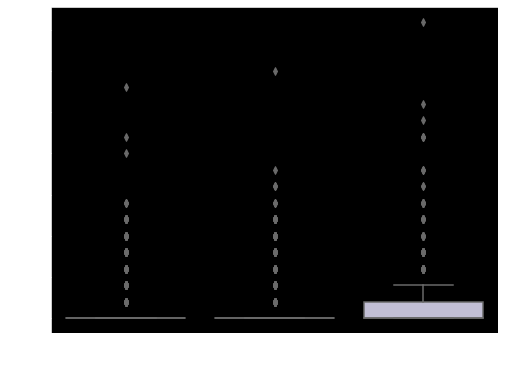

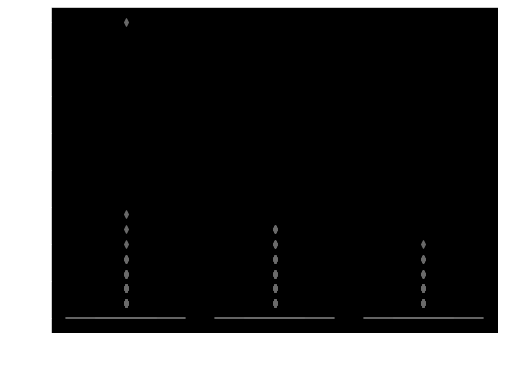

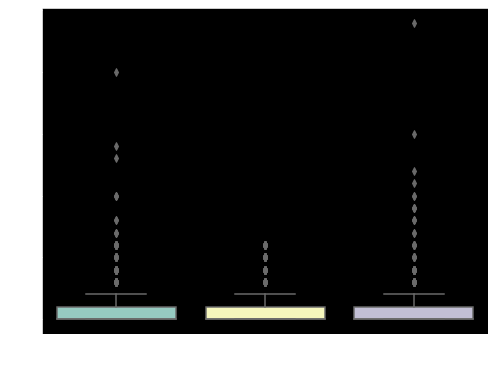

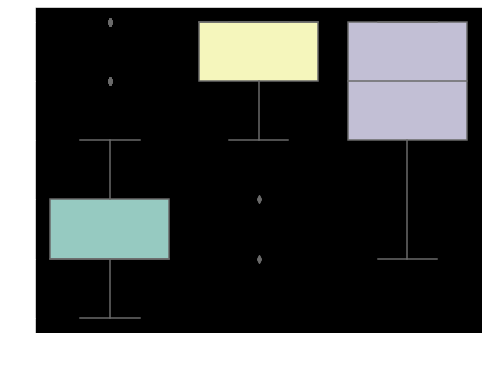

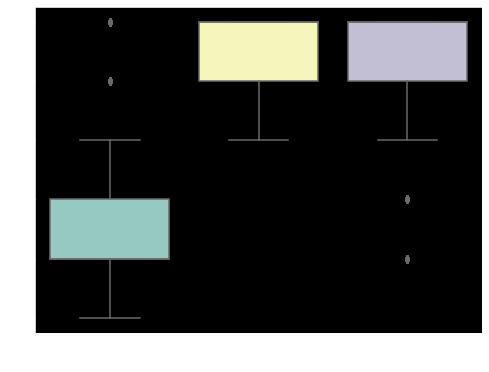

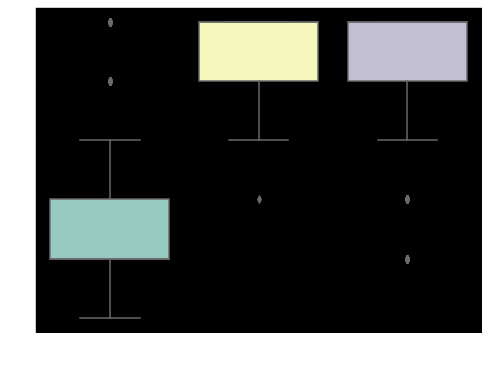

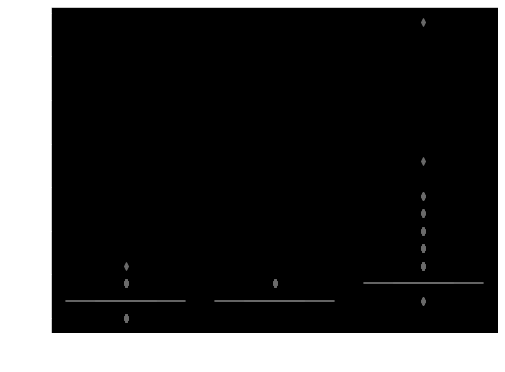

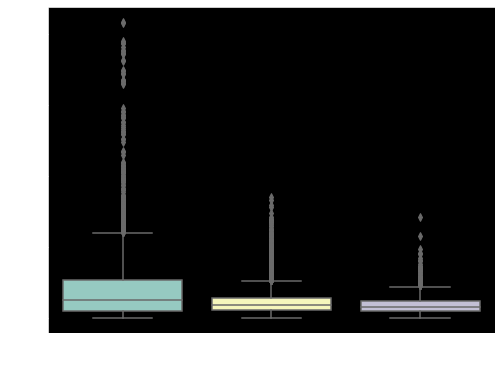

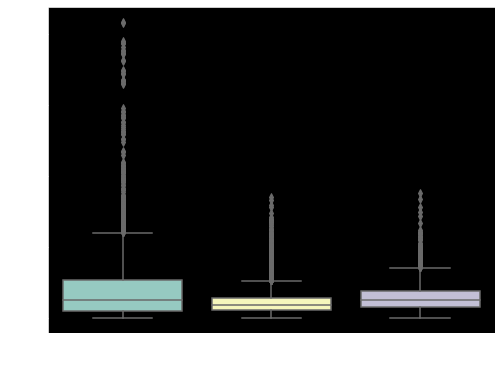

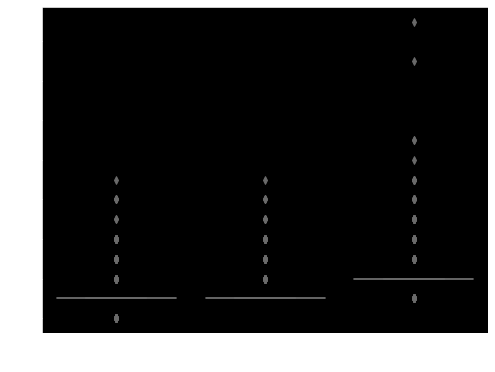

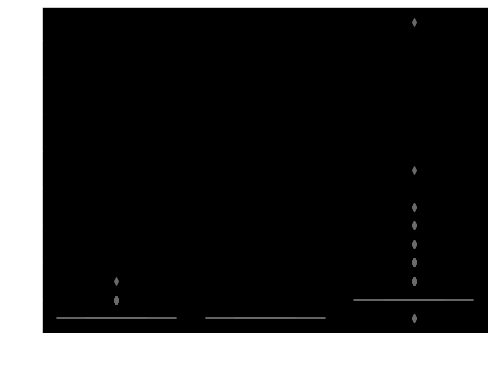

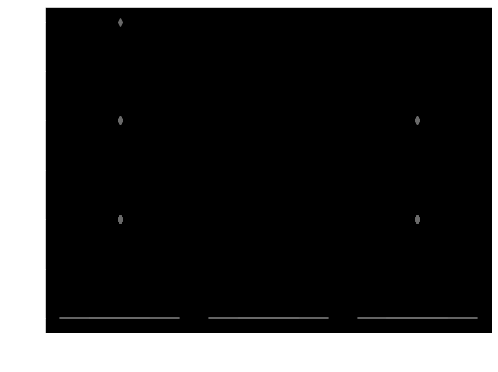

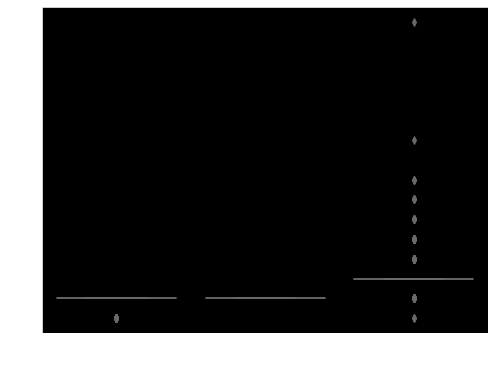

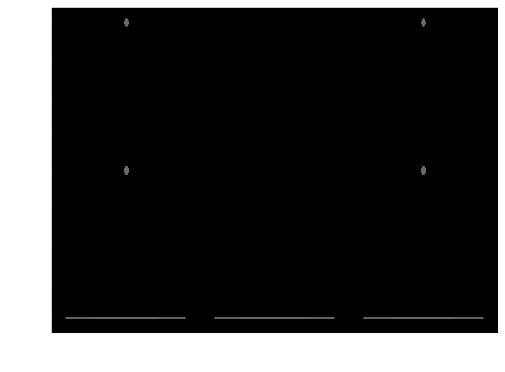

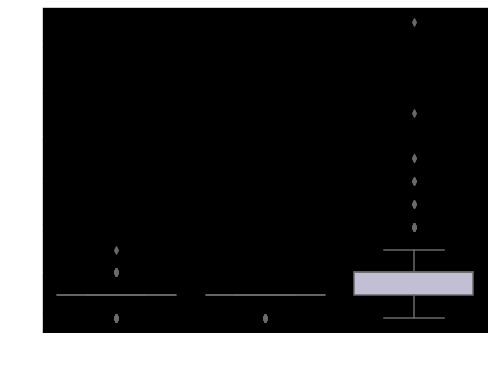

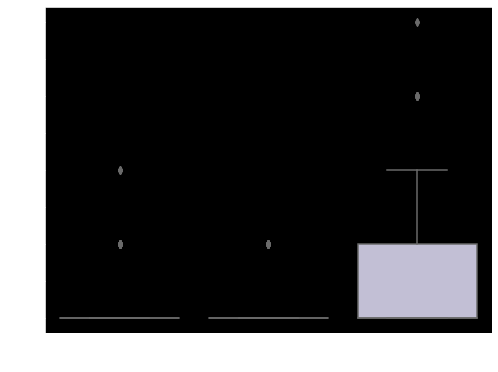

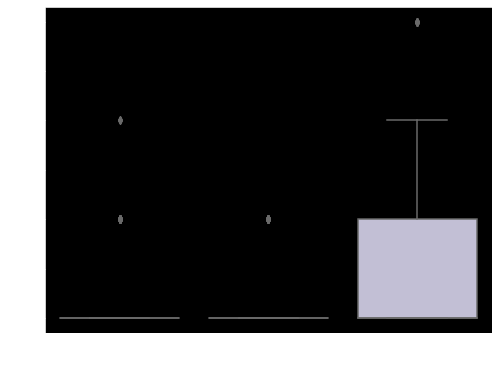

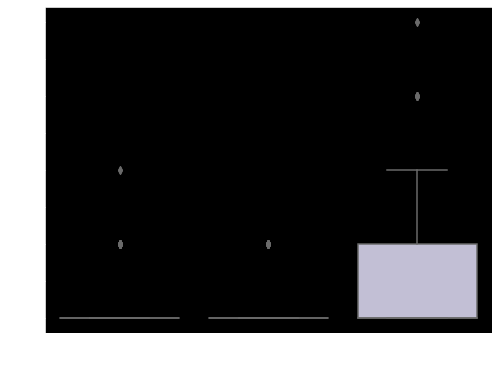

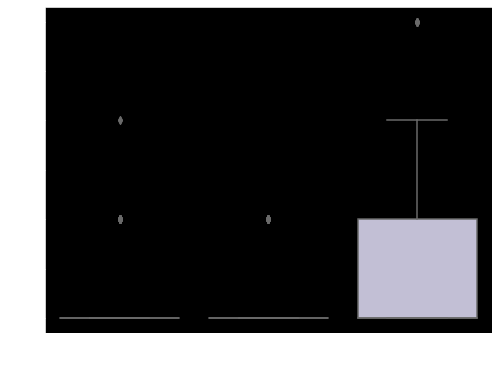

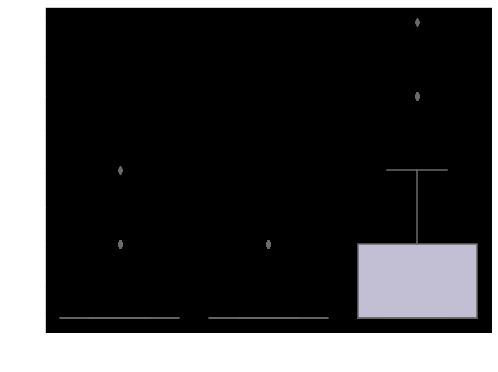

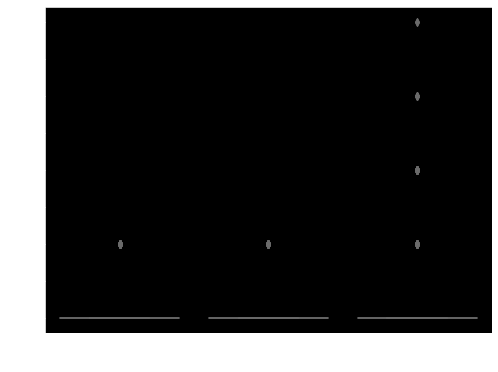

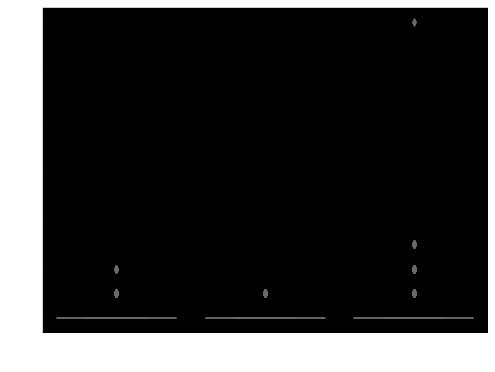

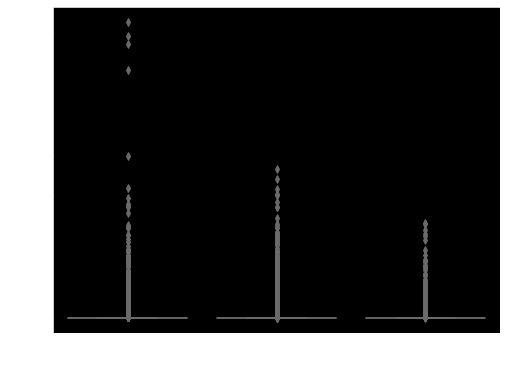

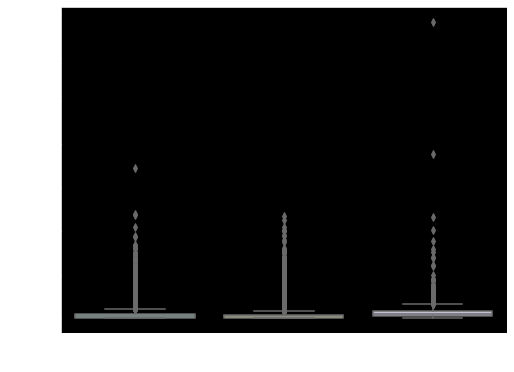

/Users/julie/PycharmProjects/misc/venv/lib/python3.7/site-packages/scipy/stats/stats.py:3650: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


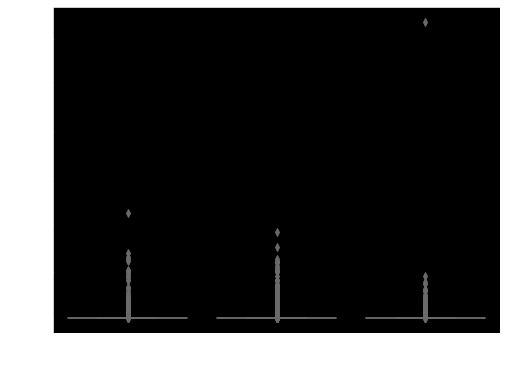

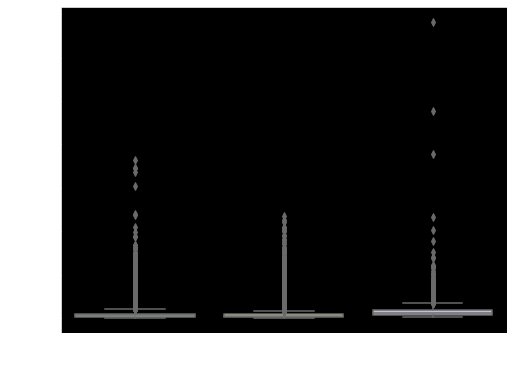

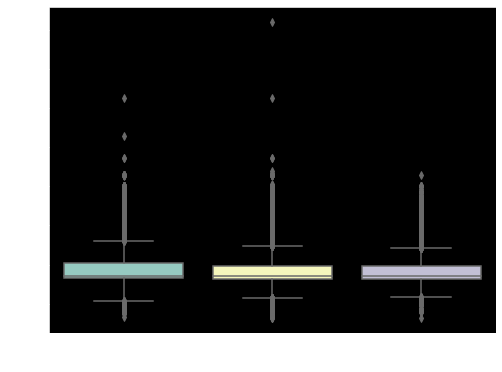

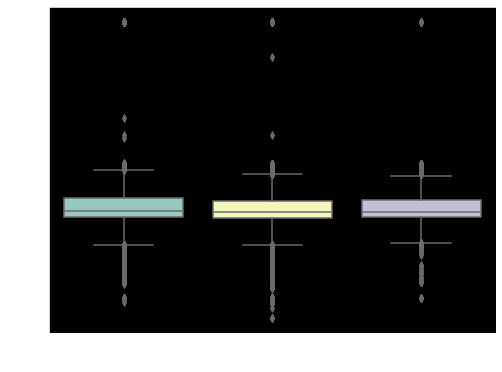

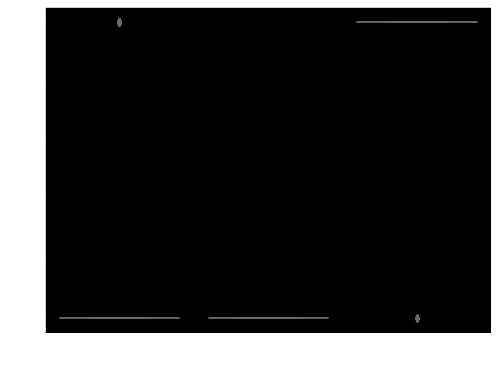

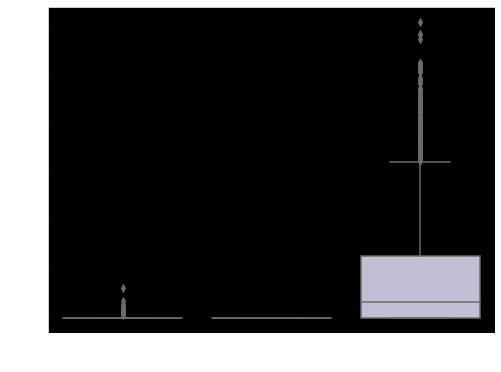

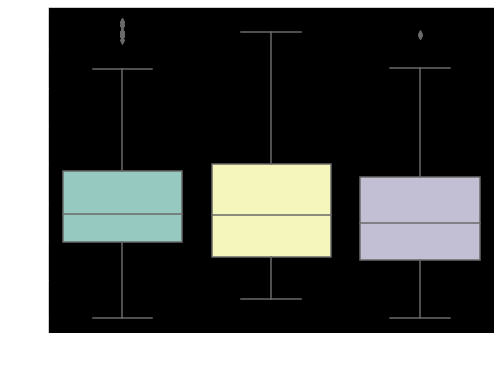

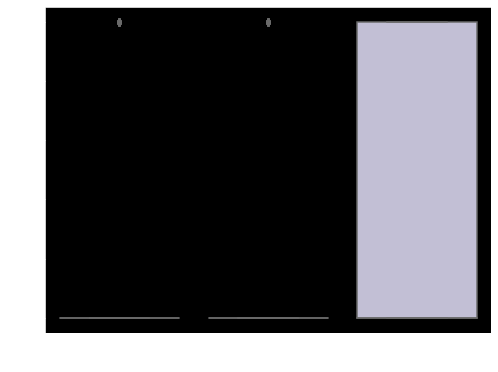

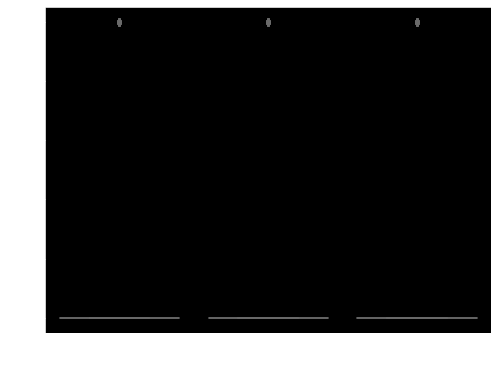

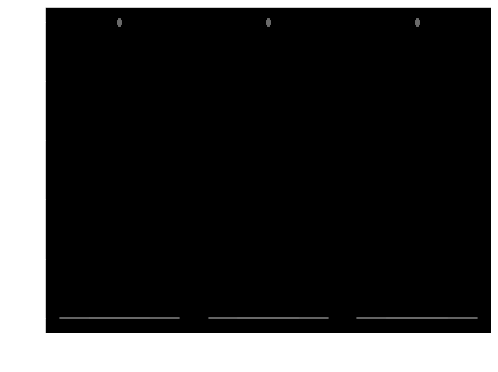

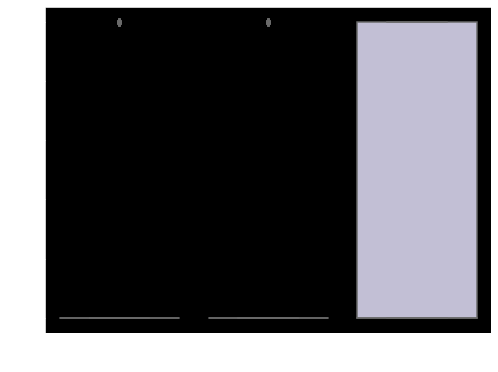

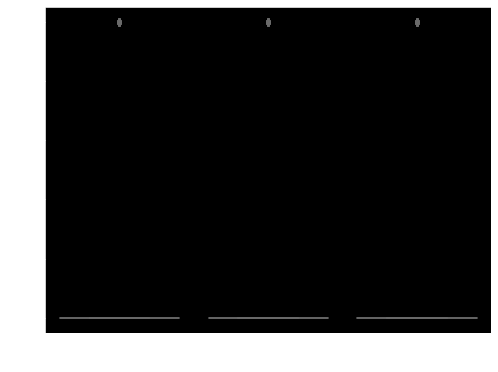

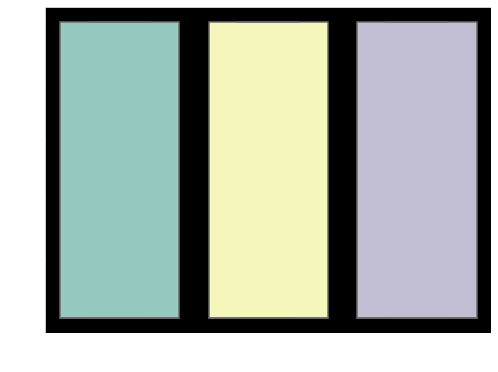

In [19]:
for col in classified_customers.columns:
    if col == 'kmeans_group':
        continue
    if col.startswith('freight'):
        continue

    this_col = classified_customers[col]
    groups = set(classified_customers['kmeans_group'])
    my_tuple = tuple(this_col[classified_customers['kmeans_group'] == group].rename(group) for group in groups)
    anova_result = stats.f_oneway(*my_tuple)

    print(col.upper())
    if anova_result.pvalue <= .05:
        print()

        plt.figure(figsize=(8,6))
        p = sns.boxplot(y=col, x='kmeans_group', data=classified_customers)

        plt.show()
        print('###')

    else:
        print('diff moyenne non significative')
        print(anova_result)


## DBSCAN

In [21]:
# for col in classified_customers.columns:
#     if col.endswith('_group'):
#         continue
#
#     this_col = classified_customers[col]
#     groups = set(classified_customers['dbscan_group'])
#     my_tuple = tuple(this_col[classified_customers['dbscan_group'] == group].rename(group) for group in groups)
#     anova_result = stats.f_oneway(*my_tuple)
#
#     if anova_result.pvalue <= .05:
#         plt.figure(figsize=(8,6))
#         sns.boxplot(y=col, x='dbscan_group', data=classified_customers)
#     else:
#         print(col, 'diff moyenne non significative')

In [22]:
unique_customers['kmeans_label'] = kmeans.labels_

In [23]:
#unique_customers.groupby(by=['kmeans_label', 'customer_state']).agg({'total_amount': 'count'})

In [24]:
#list(unique_customers['customer_state'])

In [25]:
unique_customers_numeric.groupby(by='kmeans_group').agg({'items_count_art':['min', 'mean', 'median', 'max']})

items_count_art                      
                         min      mean median  max
kmeans_group                                      
0                        0.0  0.004785    0.0  6.0
1                        0.0  0.004570    0.0  4.0
2                        0.0  0.008406    0.0  3.0

In [26]:
unique_customers_numeric.columns

Index(['price_art', 'price_body', 'price_food_drink',
       'price_home_construction', 'price_home_everyday', 'price_misc',
       'price_professional', 'price_utilities_hobbies', 'items_count_art',
       'items_count_body', 'items_count_food_drink',
       'items_count_home_construction', 'items_count_home_everyday',
       'items_count_misc', 'items_count_professional',
       'items_count_utilities_hobbies', 'review_score_min', 'review_score_max',
       'review_score_last', 'review_score_count', 'order_to_door_duration_min',
       'order_to_door_duration_max', 'nb_unique_items', 'nb_orders',
       'status_aborted_x', 'status_fulfilled_x', 'status_ongoing_x',
       'ordered_weekday', 'ordered_weekend', 'ordered_afternoon',
       'ordered_early', 'ordered_evening', 'ordered_lunch', 'ordered_morning',
       'ordered_night', 'boleto', 'credit_card', 'debit_card', 'not_defined',
       'voucher', 'total_amount', 'latitude', 'longitude',
       'bool_several_orders', 'order_freque

In [27]:
unique_customers_numeric.groupby(by='kmeans_group').agg({'price_art': 'mean'})

,price_art
kmeans_group,
0,0.946849
1,0.382890
2,0.743635


In [28]:
mean_others = pd.DataFrame()
for j in range(chosen_k):
    mean_others[j] = unique_customers_numeric[unique_customers_numeric['kmeans_group'] != j].mean()

mean_others = mean_others.transpose()
means_this = unique_customers_numeric.groupby(by='kmeans_group').agg('mean')

In [29]:
sorted_features = []
p_values = []

for col in classified_customers.columns:
    this_col = classified_customers[col]
    groups = set(classified_customers['kmeans_group'])
    my_tuple = tuple(this_col[classified_customers['kmeans_group'] == group].rename(group) for group in groups)
    anova_result = stats.f_oneway(*my_tuple)
    p_values.append(anova_result.pvalue)
    sorted_features.append(col)

/Users/julie/PycharmProjects/misc/venv/lib/python3.7/site-packages/scipy/stats/stats.py:3650: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


In [30]:
features_indexes = sorted(range(len(p_values)), key=lambda val: p_values[val])
sorted_features = [sorted_features[j] for j in features_indexes]
p_values = [p_values[j] for j in features_indexes]

In [31]:
[(p, f) for (p, f) in zip(p_values, sorted_features)]

[(0.0, 'items_count_home_everyday'),
 (0.0, 'review_score_min'),
 (0.0, 'review_score_max'),
 (0.0, 'review_score_last'),
 (0.0, 'review_score_count'),
 (0.0, 'order_to_door_duration_min'),
 (0.0, 'order_to_door_duration_max'),
 (0.0, 'nb_unique_items'),
 (0.0, 'nb_orders'),
 (0.0, 'status_aborted_x'),
 (0.0, 'status_fulfilled_x'),
 (0.0, 'status_ongoing_x'),
 (0.0, 'ordered_weekday'),
 (0.0, 'total_amount'),
 (0.0, 'bool_several_orders'),
 (0.0, 'order_frequency_days'),
 (0.0, 'kmeans_group'),
 (9.981742935634545e-257, 'credit_card'),
 (7.582031228891471e-230, 'ordered_weekend'),
 (1.59152927842697e-225, 'ordered_early'),
 (3.9554579431563525e-215, 'items_count_utilities_hobbies'),
 (4.237270428996462e-175, 'items_count_body'),
 (1.2473341585044116e-165, 'ordered_lunch'),
 (2.8497660691408612e-155, 'ordered_evening'),
 (1.2268610029151067e-146, 'price_home_everyday'),
 (7.787074857939955e-142, 'bool_home_everyday'),
 (4.094876994377637e-140, 'ordered_afternoon'),
 (1.9736382908508582e

ITEMS_COUNT_HOME_EVERYDAY p_value = 0.0
group 2 ITEMS_COUNT_HOME_EVERYDAY - ratio=HIGH mean_this_group=0.8375924680564896mean_others=0.2643521402031743

REVIEW_SCORE_MIN p_value = 0.0
group 0 REVIEW_SCORE_MIN - ratio=LOW mean_this_group=1.387797506611258mean_others=4.571371581020769
group 1 REVIEW_SCORE_MIN - ratio=HIGH mean_this_group=4.6045054375970995mean_others=1.754189647857446

REVIEW_SCORE_MAX p_value = 0.0
group 0 REVIEW_SCORE_MAX - ratio=LOW mean_this_group=1.3906309029089536mean_others=4.601466078240706

REVIEW_SCORE_LAST p_value = 0.0
group 0 REVIEW_SCORE_LAST - ratio=LOW mean_this_group=1.3883012215086261mean_others=4.586269229810258
group 1 REVIEW_SCORE_LAST - ratio=HIGH mean_this_group=4.604647850854479mean_others=1.8174056003394146

REVIEW_SCORE_COUNT p_value = 0.0

ORDER_TO_DOOR_DURATION_MIN p_value = 0.0

ORDER_TO_DOOR_DURATION_MAX p_value = 0.0

NB_UNIQUE_ITEMS p_value = 0.0

NB_ORDERS p_value = 0.0

STATUS_ABORTED_X p_value = 0.0
group 0 STATUS_ABORTED_X - ratio=HIGH

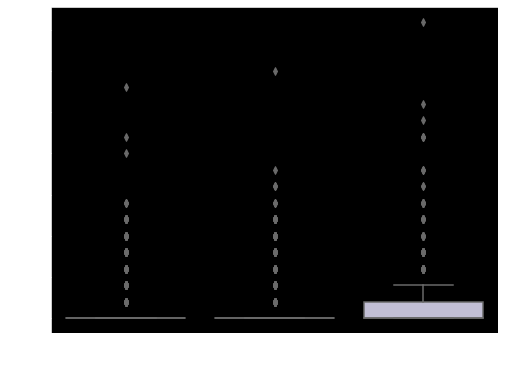

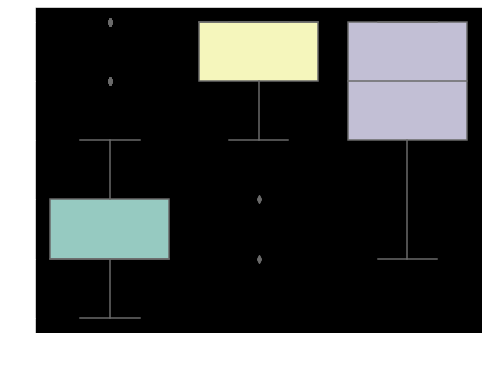

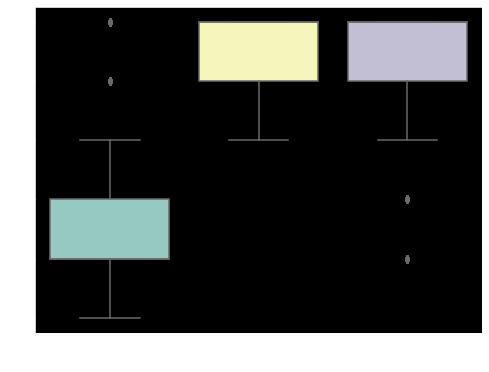

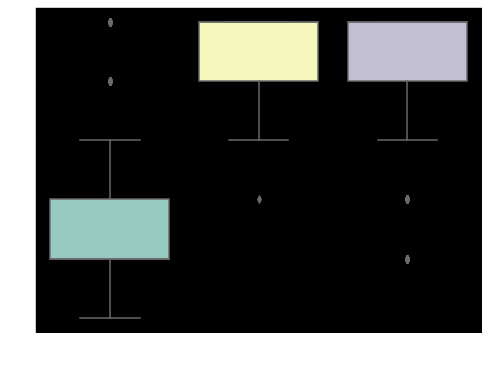

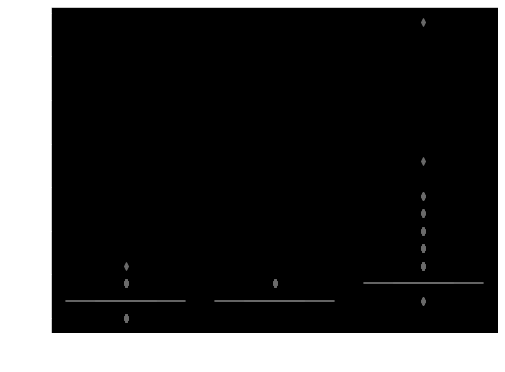

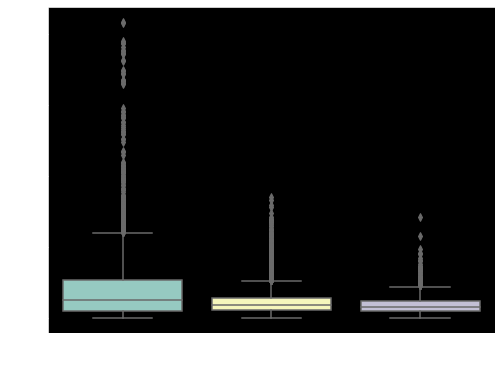

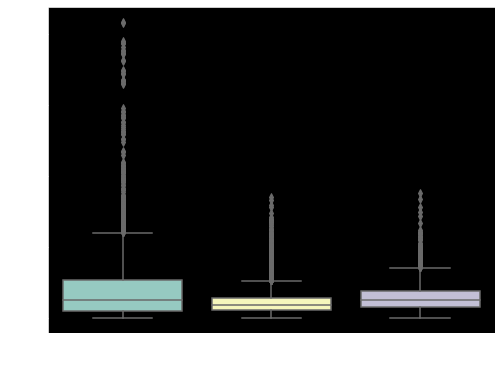

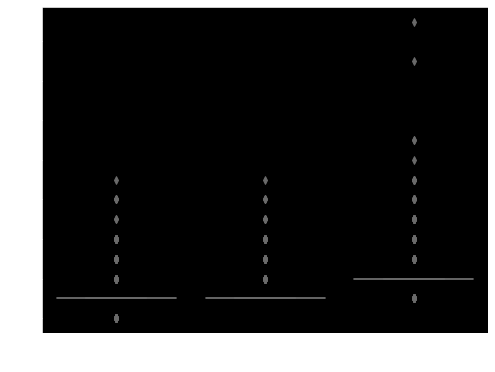

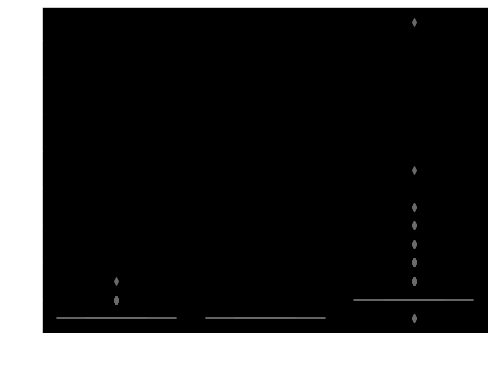

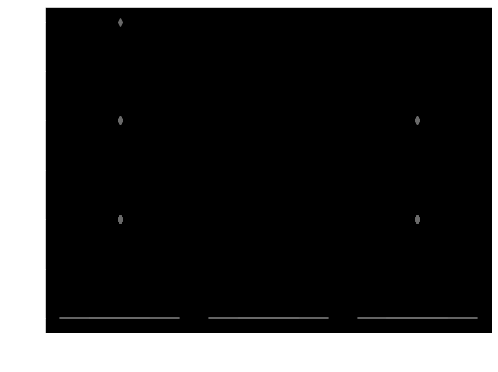

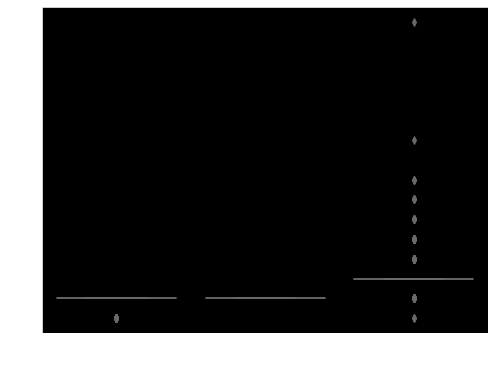

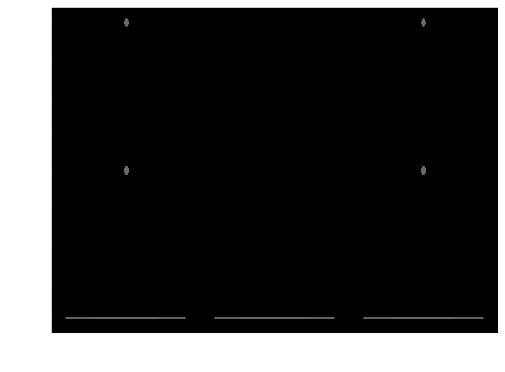

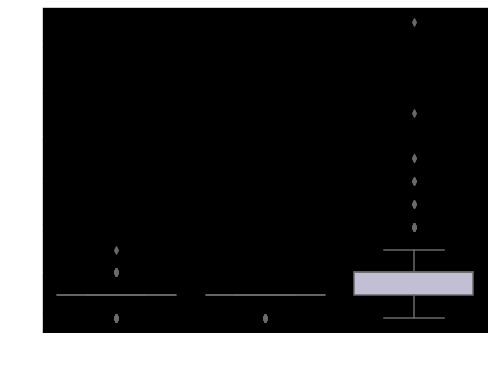

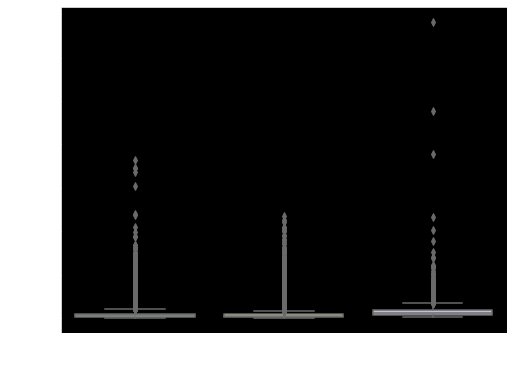

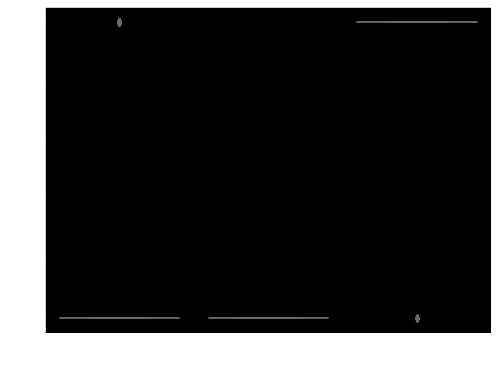

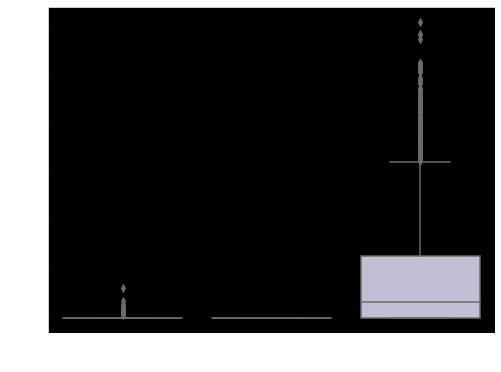

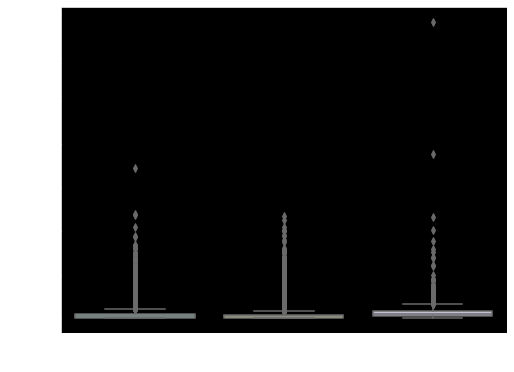

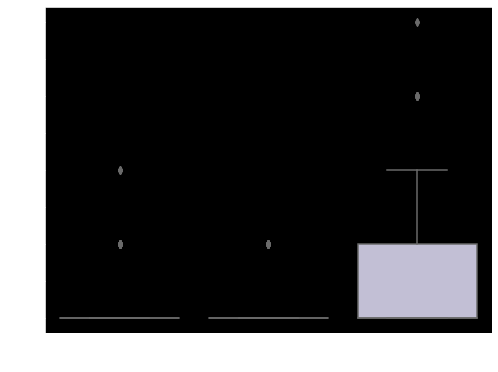

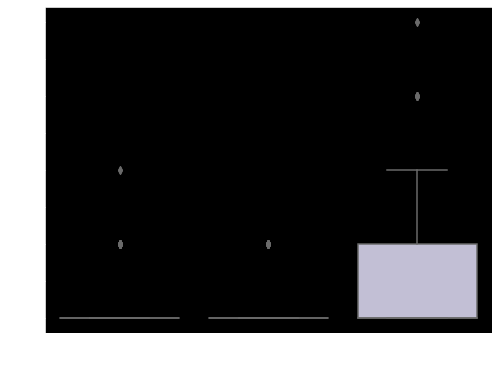

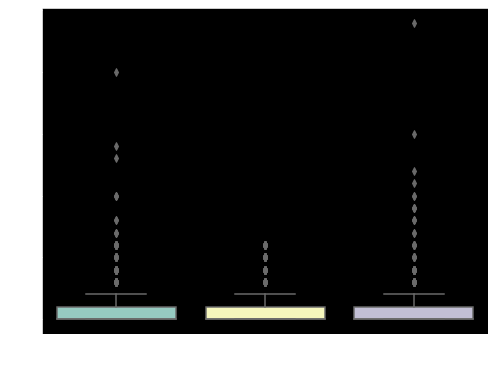

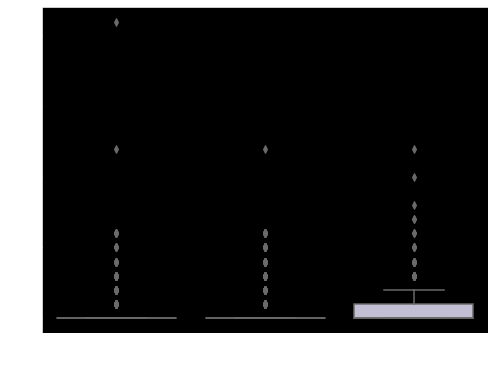

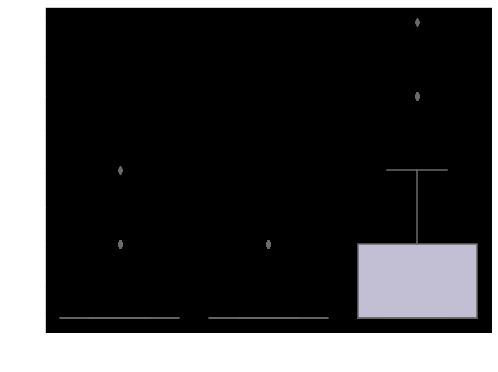

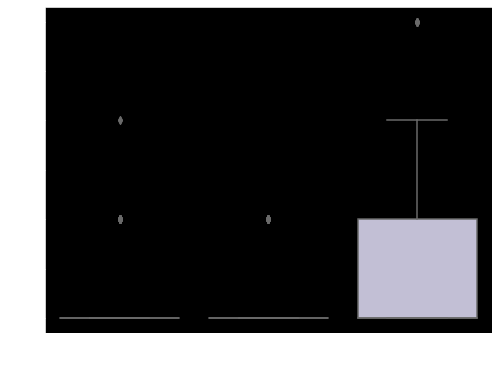

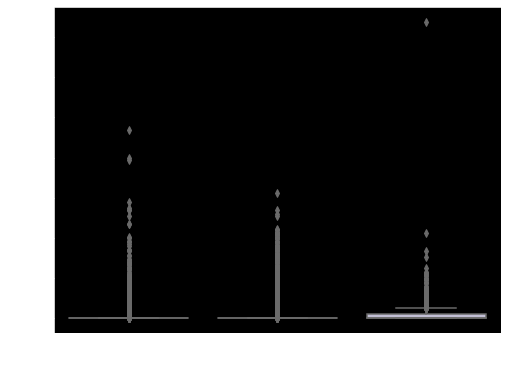

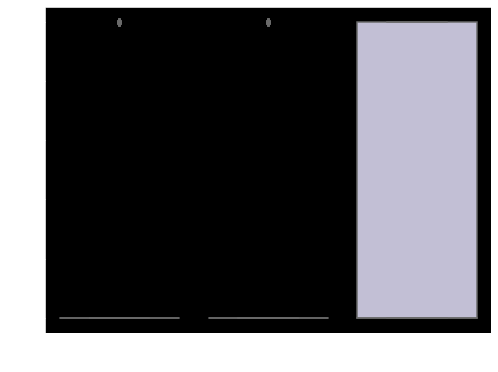

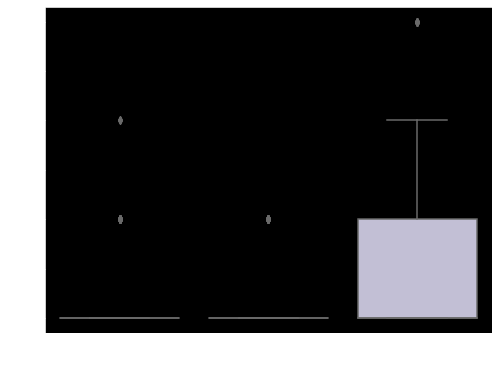

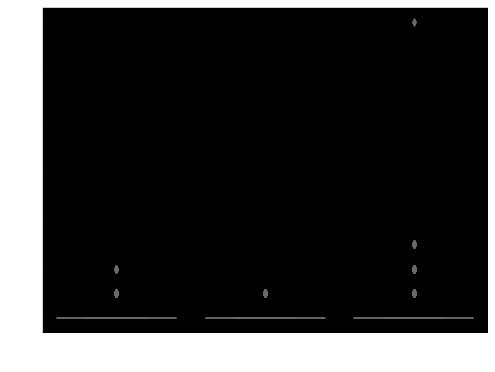

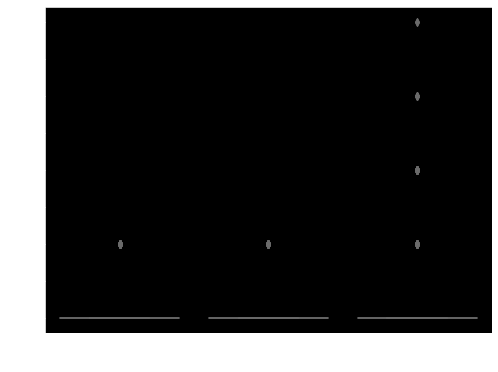

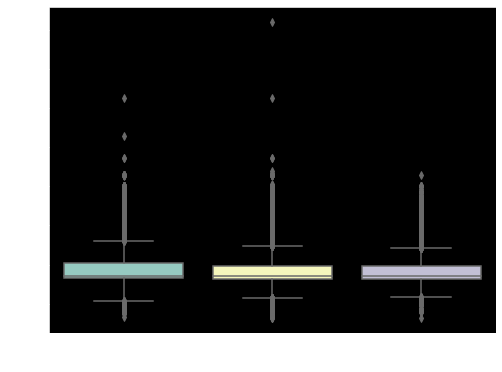

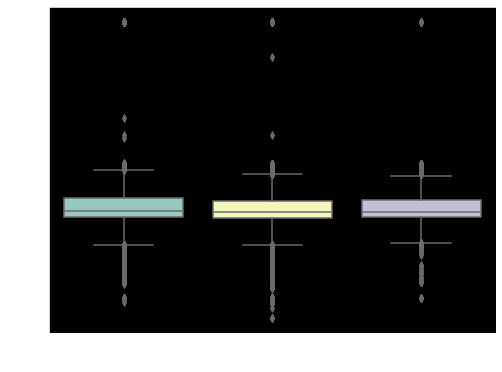

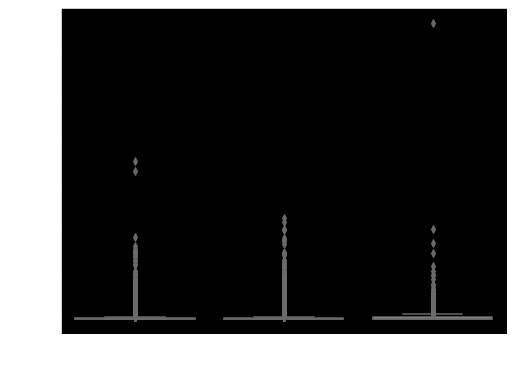

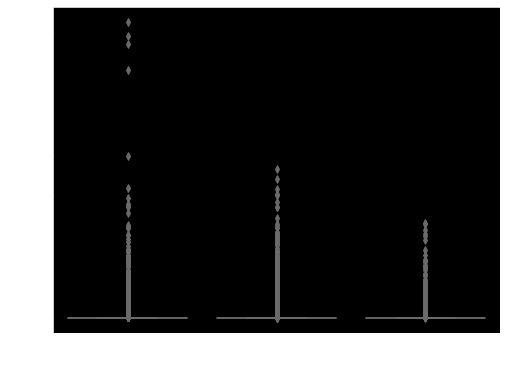

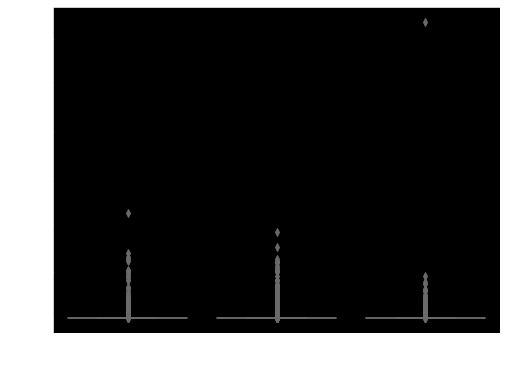

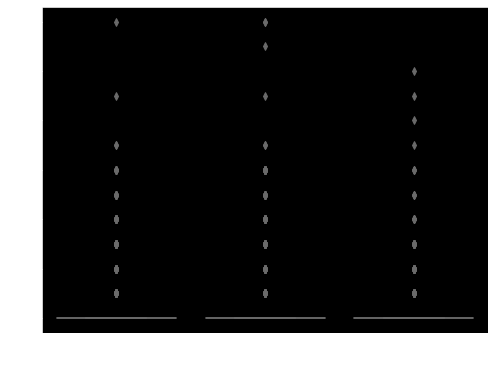

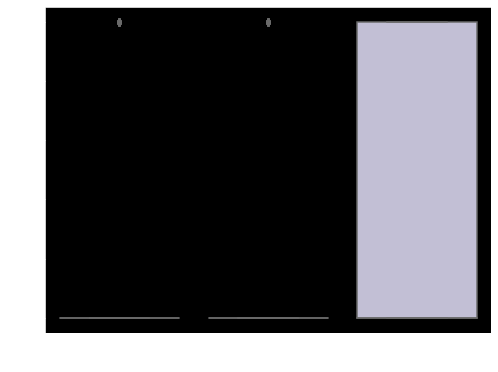

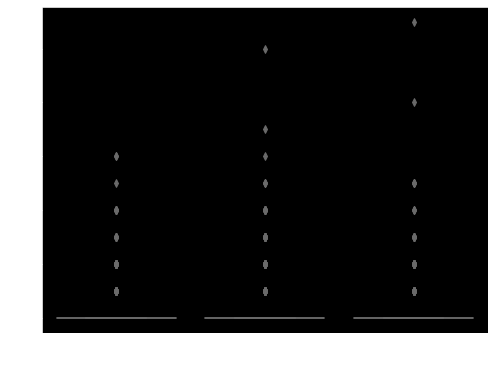

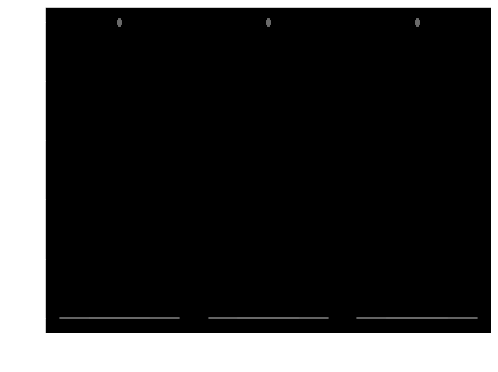

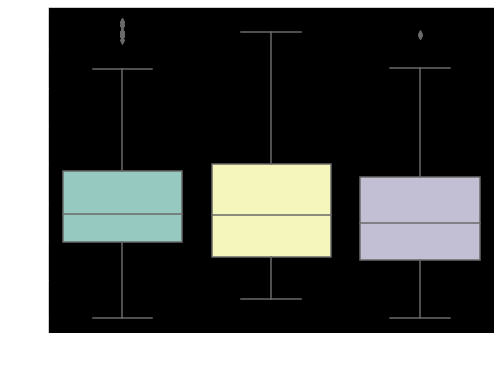

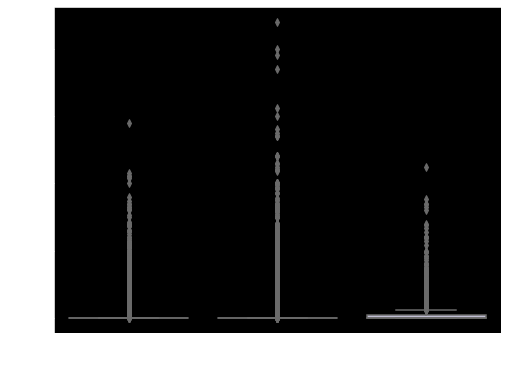

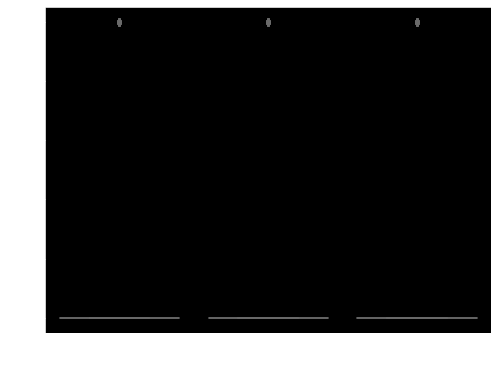

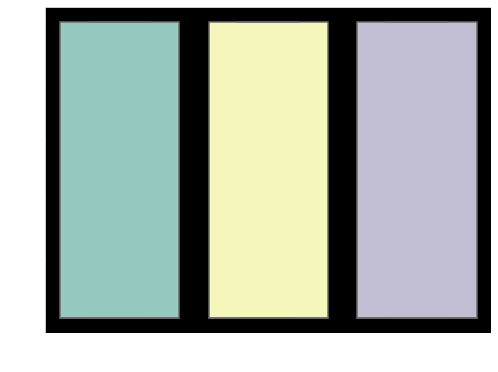

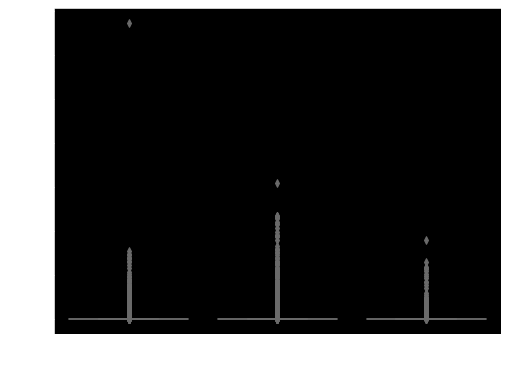

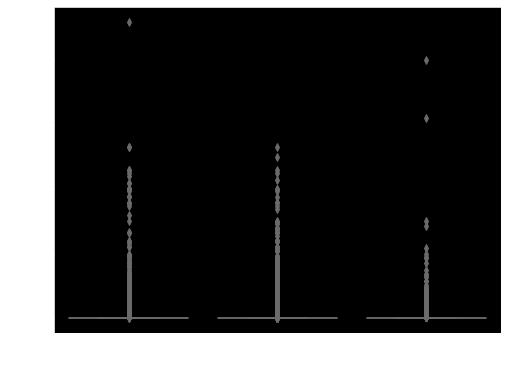

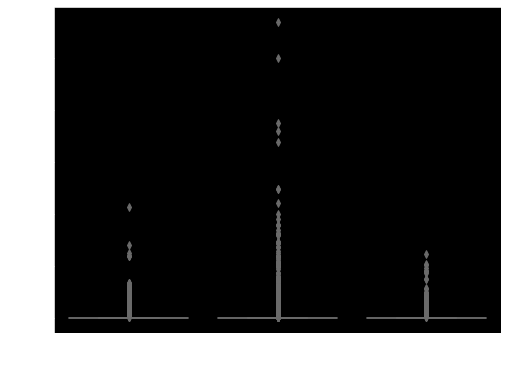

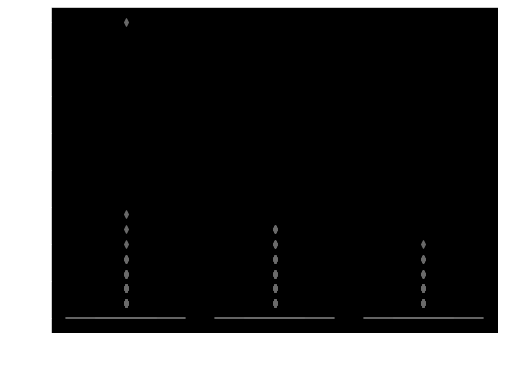

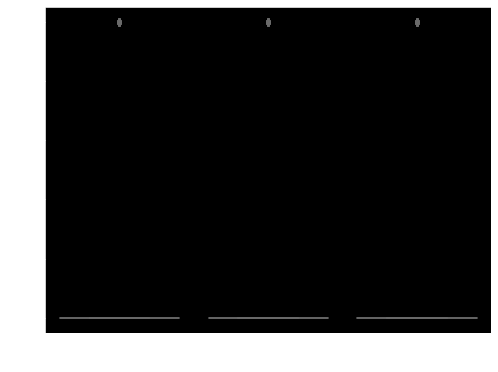

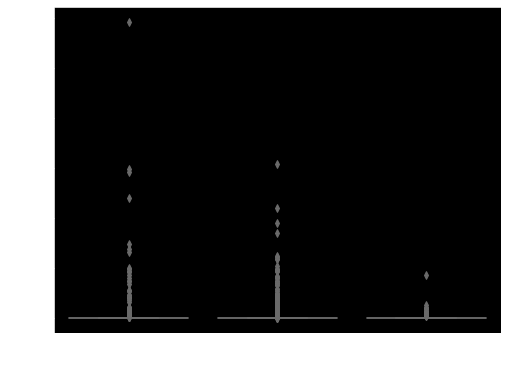

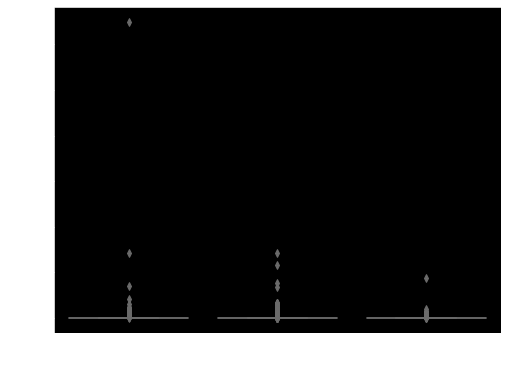

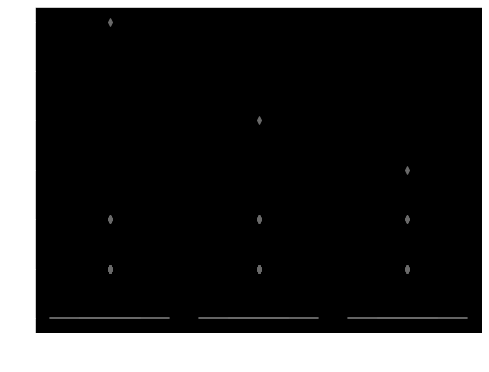

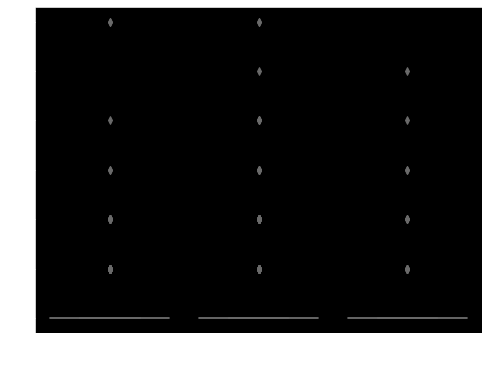

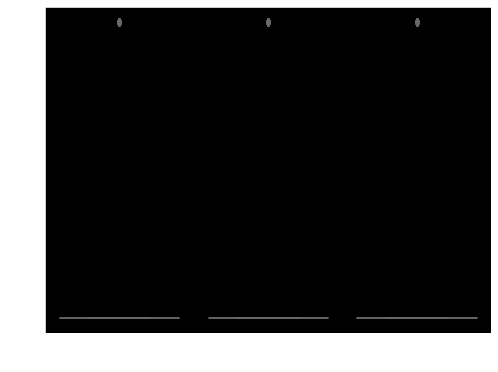

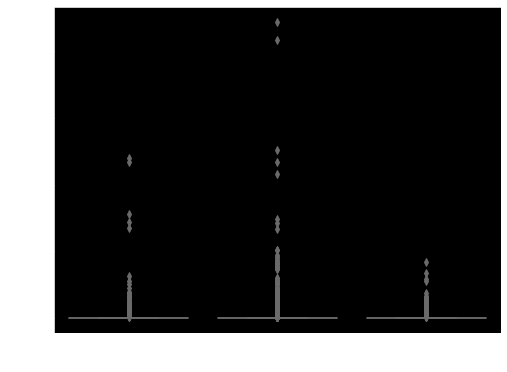

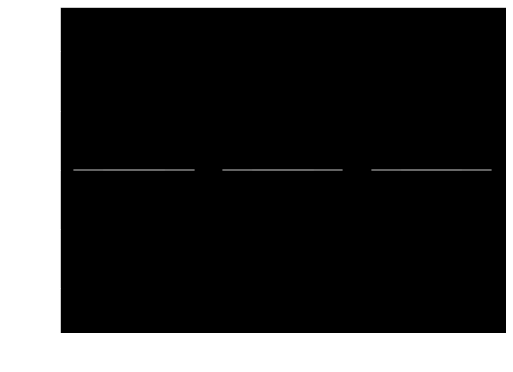

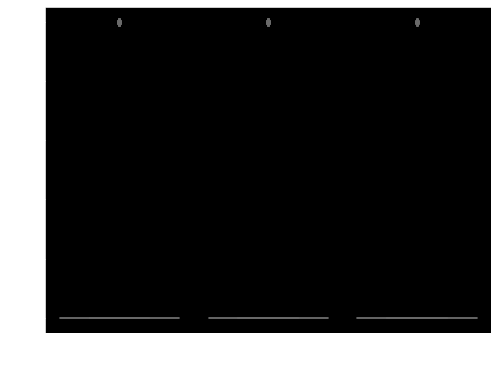

In [43]:
significance_threshold = 2.5
distinctive_features = dict({group: [] for group in range(chosen_k)})

for p_value, feature in zip(p_values, sorted_features):
    if feature == 'kmeans_group':
        continue
    if feature.startswith('freight'):
        continue

    print(feature.upper(), 'p_value =', p_value)
    info = pd.DataFrame([mean_others[feature].rename('mean_others'), means_this[feature].rename('mean_this_group')]).transpose()
    info['ratio'] = info['mean_this_group'] / info['mean_others']
    for idx in info.index:
        this_ratio = info.iloc[idx, 2]
        if this_ratio > significance_threshold:
            ratio_type = 'HIGH '
        elif this_ratio < 1/significance_threshold:
            ratio_type = 'LOW '
        else:
            continue
        my_string =  feature.upper() + ' - ' + \
                    'ratio=' + ratio_type + 'mean_this_group=' + str(info.iloc[idx, 1]) + 'mean_others=' + str(info.iloc[idx, 0])
        print('group ' + str(idx), my_string)
        distinctive_features[idx].append(my_string)

    plt.figure(figsize=(8,6))
    sns.boxplot(y=feature, x='kmeans_group', data=classified_customers)
    plt.show()
    print()

In [44]:
for group in distinctive_features:
    print('GROUP', group)
    for dis_feat in distinctive_features[group]:
        print(dis_feat)
    print()

GROUP 0
REVIEW_SCORE_MIN - ratio=LOW mean_this_group=1.387797506611258mean_others=4.571371581020769
REVIEW_SCORE_MAX - ratio=LOW mean_this_group=1.3906309029089536mean_others=4.601466078240706
REVIEW_SCORE_LAST - ratio=LOW mean_this_group=1.3883012215086261mean_others=4.586269229810258
STATUS_ABORTED_X - ratio=HIGH mean_this_group=0.07070897871804559mean_others=0.0013837983394419926
STATUS_ONGOING_X - ratio=HIGH mean_this_group=0.10332451832262939mean_others=0.0010970653501882464
BOOL_SEVERAL_ORDERS - ratio=LOW mean_this_group=0.0017000377786173025mean_others=0.03702595556885332
ORDER_FREQUENCY_DAYS - ratio=LOW mean_this_group=0.00887797506611258mean_others=1.519959109382402

GROUP 1
REVIEW_SCORE_MIN - ratio=HIGH mean_this_group=4.6045054375970995mean_others=1.754189647857446
REVIEW_SCORE_LAST - ratio=HIGH mean_this_group=4.604647850854479mean_others=1.8174056003394146
STATUS_ABORTED_X - ratio=LOW mean_this_group=0.0mean_others=0.0654433602036487
STATUS_ONGOING_X - ratio=LOW mean_this_

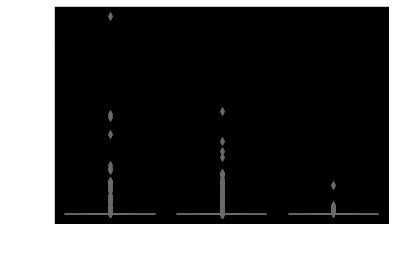

In [34]:
classified_customers['kmeans_bis'] = classified_customers['kmeans_group']
classified_customers.loc[classified_customers['kmeans_group'] != 1, 'kmeans_bis'] = 0
p = sns.boxplot(y='price_professional', x='kmeans_group', data=classified_customers)

(-1.0, 10.0)

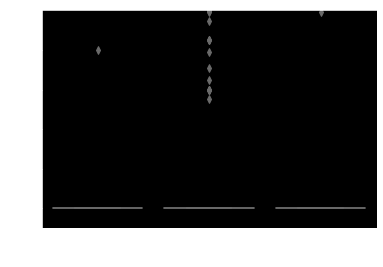

In [35]:
sns.boxplot(y='price_food_drink', x='kmeans_group', data=classified_customers)
plt.ylim([-1,10])

In [36]:
classified_customers.groupby(by='kmeans_group').agg({'price_food_drink':'mean'})

,price_food_drink
kmeans_group,
0,2.146104
1,2.996548
2,5.996698


(-1.0, 10.0)

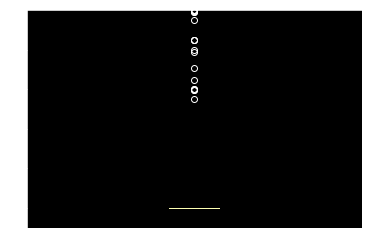

In [37]:
plt.boxplot(classified_customers['price_food_drink'])
plt.ylim([-1,10])

In [38]:
classified_customers['price_food_drink'].quantile(.98)

45.8

In [39]:
classified_customers['price_food_drink'].quantile(.25)

0.0

In [40]:
classified_customers['items_count_food_drink'].quantile(.98)

1.0

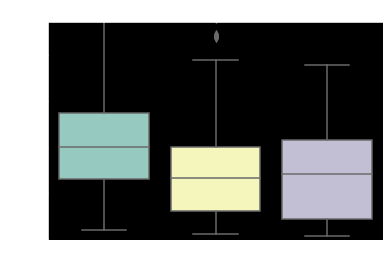

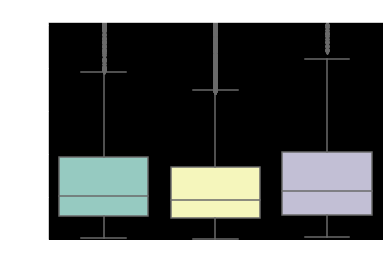

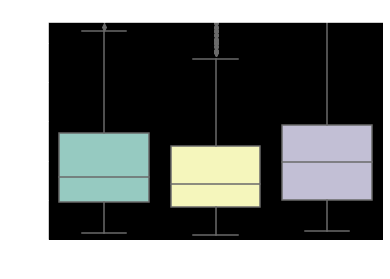

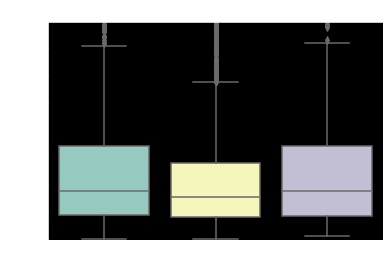

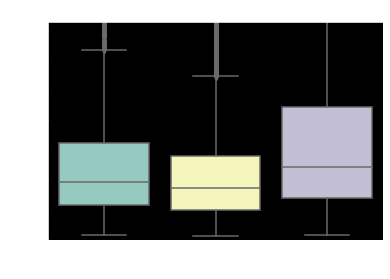

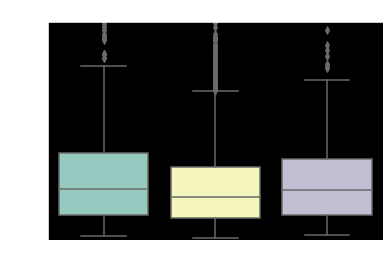

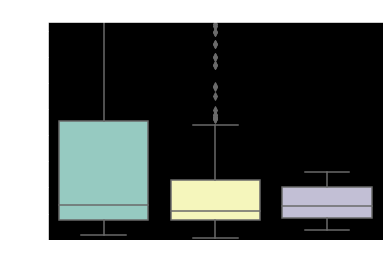

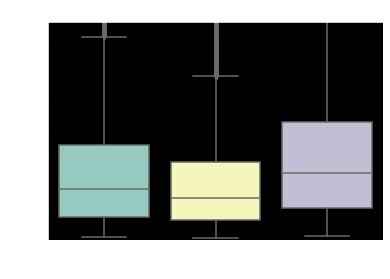

In [41]:
for c in categories:
    column = 'price_' + c
    bought_this = classified_customers[classified_customers['bool_' + c] == 1]
    sns.boxplot(data=bought_this, x='kmeans_group', y=column)
    plt.ylim([-1,bought_this[column].quantile(.95)])
    plt.title('Price spent in ' + c.replace('_', ' ').title() + ' (amongst buyers)')
    plt.show()

In [42]:
unique_customers_numeric[unique_customers_numeric['bool_several_orders'] == True]['order_frequency_days'].mean()

40.72839506172839

délai moyen entre 2 commandes = 40 jours
